In [54]:
import pandas as pd 
import numpy as np
import seaborn as sns 
from urls import data_urls

In [55]:
dados_treino = pd.read_csv(data_urls['dados_treino'])
dados_teste =  pd.read_csv(data_urls['dados_teste'])
feriados = pd.read_csv(data_urls['feriados'])
preco_petroleo = pd.read_csv(data_urls['preco_petroleo'])
lojas = pd.read_csv(data_urls['lojas'])
transacoes = pd.read_csv(data_urls['transacoes'])


# Introdução

As técnicas de previsão de séries temporais assumem uma importância crítica no panorama empresarial contemporâneo, dada a sua capacidade de antecipar tendências futuras e comportamentos de mercado com base na análise de dados históricos. Em um ambiente de negócios caracterizado por volatilidade, incerteza, complexidade e ambiguidade, a habilidade de prever com precisão eventos futuros torna-se um diferencial competitivo fundamental. Empresas que dominam essas técnicas podem otimizar a gestão de estoques, aprimorar a alocação de recursos, antecipar mudanças na demanda dos consumidores e ajustar estratégias de marketing de acordo com projeções futuras. Além disso, a previsão de séries temporais é vital para a tomada de decisões financeiras estratégicas, como investimentos e orçamentos, permitindo que as organizações se posicionem de maneira proativa frente às oportunidades e desafios do mercado. Portanto, a adoção dessas técnicas representa não apenas uma ferramenta para a maximização da eficiência operacional, mas também um elemento estratégico para a sustentabilidade e crescimento a longo prazo no cenário empresarial global.

Neste artigo exploraremos técnicas de previsão de séries temporais utilizando algorítimos de machine learning, passando por todas as etapas do processo, desde a limpeza e preparação dos dados, até a criação e validação dos modelos criados para prever as futuras tendências para as vendas da cadeia de lojas. Para isso foi utilizado um dataset das vendas  de produtos de uma rede de lojas do equador entre os anos de 2013 e 2017. 





# Visualizando os dados

**Fazer algumas visualizações**


## Produtos por categoria da loja 1

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3990792064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  produtos_loja1['date'] = pd.to_datetime(produtos_loja1['date'])


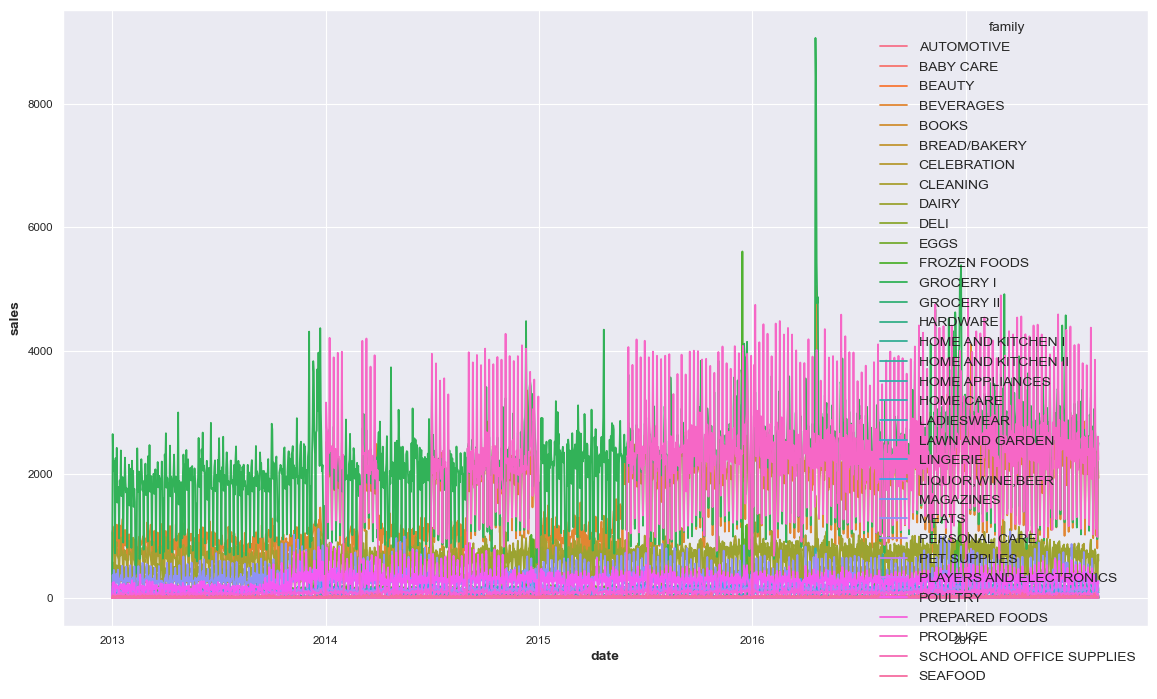

In [56]:
for str in dados_treino['store_nbr'].unique():
    produtos_loja1 = dados_treino.loc[dados_treino['store_nbr']== str]
    break
produtos_loja1['date'] = pd.to_datetime(produtos_loja1['date'])
sns.set_palette('Accent')
sns.set_style('darkgrid')
bx = sns.lineplot(data=produtos_loja1, x='date', y='sales',hue='family')
bx.figure.set_size_inches(14,8)

## Adicionando a cotação do petróleo ao dataset

O conjunto dos dados representa os registros de venda de uma rede de lojas do Equador durante um período. A econômia do equador extremamente dependente do petróleo, portanto é interesante apresentar isso ao nosso modelo para que ele consiga detectar qualquer correlação na variação do preço e das vendas.

Para isso foi necessário fazer alguns tratamentos nos dados relacionados ao preço do petróleo.

**Falar sobre covariantes aqui**



#### Tratando dados faltantes para covariante

In [57]:
# Criando um dataset com todas as datas em que queremos análisar as vendas 

total_datas = np.concatenate((dados_treino['date'].unique(),dados_teste['date'].unique()))
nanobj = np.array([np.nan for d in total_datas])
dicio = {'date': total_datas,
        'preco': nanobj }
preco_petroleo_todos = pd.DataFrame(data=dicio)

#Adicionando a cotação do petroleo para todas as datas disponíveis 

for i in preco_petroleo.itertuples():
   for j in preco_petroleo_todos.itertuples():
        if i.date == j.date:
            preco_petroleo_todos.at[j.Index,'preco'] = i.dcoilwtico
            break

#Tratando dias em que a cotação do petroleo não foi registrada.
#um dia com a cotação de petróleo não registrada recebe o valor do próximo dia em que a cotação foi registrada
#Essa forma de tratamento é interessante pois preserva o comportamento do preço durante a série temporal

for i in preco_petroleo_todos.itertuples():
    if np.isnan(i.preco) == True:
        for j in preco_petroleo_todos[i.Index+1:].itertuples():
            if np.isnan(j.preco) == False:
                preco_petroleo_todos.at[i.Index,'preco'] = j.preco
                break
 

<Axes: xlabel='date', ylabel='preco'>

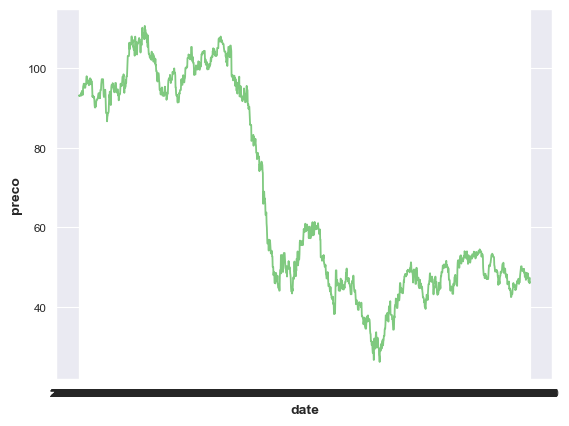

In [58]:
 sns.lineplot(data = preco_petroleo_todos, x= 'date', y = 'preco')

In [59]:
#Criando dicionário com cotação diária e criando colunas nos datasets de teste e treino

dicio_petroleo = {}
for i in preco_petroleo_todos.itertuples():
    dicio_petroleo[i.date] = i.preco

petroleo_treino = []
for i in dados_treino.itertuples():
    petroleo_treino.append(dicio_petroleo[i.date])
    
petroleo_teste = []
for i in dados_teste.itertuples():
    petroleo_teste.append(dicio_petroleo[i.date])
    
complete_data_treino = dados_treino
complete_data_treino['Petroleo'] = petroleo_treino

complete_data_teste = dados_teste
complete_data_teste['Petroleo'] = petroleo_teste


## Adicionando metadados das lojas 

**Falar sobre covariantes estáticas aqui**

In [60]:
complete_data_treino = pd.merge(complete_data_treino,lojas,how='inner',on = 'store_nbr')
complete_data_teste = pd.merge(complete_data_teste,lojas,how='inner',on = 'store_nbr')

In [61]:
complete_data_treino.head()

,id,date,store_nbr,family,sales,onpromotion,Petroleo,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Quito,Pichincha,D,13


In [62]:
from sklearn.preprocessing import OrdinalEncoder

complete_data_encoded_treino = complete_data_treino
oe  = OrdinalEncoder()

family = oe.fit_transform(complete_data_treino[['family']])
city = oe.fit_transform(complete_data_treino[['city']])
state = oe.fit_transform(complete_data_treino[['state']])
types = oe.fit_transform(complete_data_treino[['type']])
cluster = oe.fit_transform(complete_data_treino[['cluster']])

complete_data_encoded_treino[['family']] = family
complete_data_encoded_treino[['city']] = city
complete_data_encoded_treino[['state']] = state
complete_data_encoded_treino[['type']] = types
complete_data_encoded_treino[['cluster']] = cluster


In [71]:
complete_data_encoded_treino[['family','city','state','type','cluster']].head()

,family,city,state,type,cluster
0,0.0,18.0,12.0,3.0,12.0
1,1.0,18.0,12.0,3.0,12.0
2,2.0,18.0,12.0,3.0,12.0
3,3.0,18.0,12.0,3.0,12.0
4,4.0,18.0,12.0,3.0,12.0


# Organizando a sequência das séries



In [64]:

multi_series_data = []
for str in complete_data_encoded_treino['store_nbr'].unique():
    for f in complete_data_encoded_treino['family'].unique():
        serie = complete_data_treino.loc[(complete_data_treino['store_nbr']== str) & (complete_data_treino['family']== f)]
        serie['date'] = pd.to_datetime(serie['date'])
        multi_series_data.append(serie)
    

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serie['date'] = pd.to_datetime(serie['date'])
C:\Users\Felipe\AppData\Local\Temp\ipykernel_20788\3986689722.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [74]:
a = multi_series_data[0].iloc[0]
print(a.cluster)

12.0


In [77]:
from darts import TimeSeries

multi_serie_TimeSeries = []
for serie in multi_series_data:
    keys = serie.iloc[0]
    dataf_static = {'family':[keys.family],
                   'city':[keys.city],
                   'state':[keys.state],
                   'type': [keys.type],
                   'cluster':[keys.cluster]}
    
    static_cov = pd.DataFrame(data=dataf_static)
    
    new = TimeSeries.from_dataframe(df=serie,time_col='date',
                                    value_cols='sales',
                                    static_covariates=static_cov,
                                    fill_missing_dates=True,
                                    fillna_value = 0)
    
    multi_serie_TimeSeries.append(new)
    
    

In [79]:
multi_serie_TimeSeries[0]

<TimeSeries (DataArray) (date: 1688, component: 1, sample: 1)>
array([[[0.]],

       [[2.]],

       [[3.]],

       ...,

       [[1.]],

       [[1.]],

       [[4.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-08-15
  * component  (component) object 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  static_covariates  family  city  state  type  cluster...
    hierarchy:          None

# Testes

# Modelo com darts

**Explicar o porque usar o darts**
**Criar configuração XGboost**
**Encode e Normaliza**
**Criar modelo com darts**

# Testes e resultados 
**Scorre das predições**
**Visualização das predições**